In [2]:
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)
from minisom import MiniSom

In [3]:
# Trains a Self-Organizing Map (SOM) on the input data
def fit_som(data: np.ndarray, grid: Tuple[int, int] = (22, 22), seed: int = 42) -> MiniSom:
    rows, cols = grid  # SOM grid dimensions
    som = MiniSom(
        x=rows, y=cols,
        input_len=data.shape[1],         # Number of features
        sigma=3.0,                       # Spread of the neighborhood
        learning_rate=0.5,               # Speed of learning
        neighborhood_function="gaussian",# Type of neighborhood function
        random_seed=seed                 # For reproducibility
    )
    som.random_weights_init(data)       # Initialize weights randomly
    som.train_batch(data, num_iteration=10_000, verbose=False)  # Train the SOM
    return som

# Creates a lookup table from each SOM node (BMU) to a majority label
def majority_vote_lookup(som: MiniSom, data: np.ndarray, labels: np.ndarray) -> Dict[Tuple[int, int], int]:
    vote: Dict[Tuple[int, int], List[int]] = {}

    for vec, lbl in zip(data, labels):                  # Go through each data point and its label
        bmu = som.winner(vec)                           # Find best-matching unit (BMU) for the vector
        vote.setdefault(bmu, []).append(lbl)            # Collect all labels that map to this BMU

    # Assign each BMU the most common label (rounded average)
    return {bmu: int(round(np.mean(v))) for bmu, v in vote.items()}

# Predict labels for new data using the trained SOM and the vote map
def predict_som(som: MiniSom, vote_map: Dict[Tuple[int, int], int], data: np.ndarray) -> np.ndarray:
    # For each input vector, find its BMU and use the vote_map to assign a predicted label
    return np.array([vote_map.get(som.winner(v), 0) for v in data])


In [ ]:
# Performs cross-validation using a Self-Organizing Map (SOM)
def som_cross_validate(df: pd.DataFrame, feature_cols: List[str], grid: Tuple[int, int] = (22, 22)) -> List[float]:
    accuracies = []

    # Loop over each fold in the dataset
    for fold in sorted(df["Fold"].unique()):
        # Split into training and validation sets
        train_df = df[df["Fold"] != fold]
        val_df = df[df["Fold"] == fold]

        # Scale features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_df[feature_cols])
        X_val = scaler.transform(val_df[feature_cols])
        y_train = train_df["Label"].values
        y_val = val_df["Label"].values

        # Train SOM and assign labels to nodes via majority voting
        som = fit_som(X_train, grid)
        vote_map = majority_vote_lookup(som, X_train, y_train)
        
        # Predict labels for validation set
        y_pred = predict_som(som, vote_map, X_val)

        # Calculate accuracy
        acc = (y_pred == y_val).mean()
        accuracies.append(float(acc))
        print(f"Fold {fold+1}: accuracy = {acc:.4f}")

    # Print summary of results
    print("\n SOM Validation Summary ")
    for i, a in enumerate(accuracies, 1):
        print(f"Fold {i}: {a:.4f}")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Standard Deviation: {np.std(accuracies):.4f}")
    
    return accuracies

In [ ]:
# Trains SOM on the full dataset and visualizes performance
def som_visual_evaluation(df: pd.DataFrame, feature_cols: List[str], grid=(22, 22), save_dir="som_figs"):
    Path(save_dir).mkdir(exist_ok=True)  # Create directory to save plots

    # Scale input features
    scaler = StandardScaler()
    X = scaler.fit_transform(df[feature_cols])
    y = df["Label"].values  # Ground truth labels

    # Train SOM and assign labels to neurons
    som = fit_som(X, grid)
    vote_map = majority_vote_lookup(som, X, y)

    # Predict labels using the trained SOM
    y_pred = predict_som(som, vote_map, X)

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.savefig(Path(save_dir) / "som_confusion.png", dpi=300, bbox_inches="tight")
    plt.show(block=True)

    # ROC Curve 
    # Use negative quantization error as a pseudo-confidence score
    dists = np.array([som.quantization_error(np.array([v])) for v in X])
    scores = -dists  # Lower distance = higher confidence
    fpr, tpr, _ = roc_curve(y, scores)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    plt.title(f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.savefig(Path(save_dir) / "som_roc.png", dpi=300, bbox_inches="tight")
    plt.show(block=True)

    # Precision-Recall Curve 
    precision, recall, _ = precision_recall_curve(y, scores)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision-Recall Curve")
    plt.savefig(Path(save_dir) / "som_pr.png", dpi=300, bbox_inches="tight")
    plt.show(block=True)

In [ ]:
import time
import psutil
import os

# Performs cross-validation using a Self-Organizing Map (SOM)
def som_cross_validate(df: pd.DataFrame, feature_cols: List[str], grid: Tuple[int, int] = (22, 22)) -> List[float]:
    accuracies = []
    process = psutil.Process(os.getpid())

    # === Resource Monitoring Start ===
    overall_start_time = time.time()
    overall_start_ram = process.memory_info().rss / 1024 / 1024  # in MB
    overall_start_cpu = psutil.cpu_percent(interval=1)

    # Loop over each fold in the dataset
    for fold in sorted(df["Fold"].unique()):
        train_df = df[df["Fold"] != fold]
        val_df = df[df["Fold"] == fold]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_df[feature_cols])
        X_val = scaler.transform(val_df[feature_cols])
        y_train = train_df["Label"].values
        y_val = val_df["Label"].values

        som = fit_som(X_train, grid)
        vote_map = majority_vote_lookup(som, X_train, y_train)
        y_pred = predict_som(som, vote_map, X_val)
        
        # plot U-Matrix for each fold
        plt.figure(figsize=(10, 8))
        u_matrix = som.distance_map()
        plt.imshow(u_matrix, cmap='bone_r')
        plt.colorbar(label='Distance')
        plt.title(f'SOM U-Matrix - Fold {fold+1}')
        plt.show()(block=True)
        plt.savefig(f"som_umatrix_fold_{fold+1}.png", dpi=300, bbox_inches="tight")
        
        # Calculate accuracy
        acc = (y_pred == y_val).mean()
        accuracies.append(float(acc))
        print(f"Fold {fold+1}: accuracy = {acc:.4f}")

    # === Resource Monitoring End ===
    overall_end_time = time.time()
    overall_end_ram = process.memory_info().rss / 1024 / 1024  # in MB
    overall_end_cpu = psutil.cpu_percent(interval=1)

    # Print fold-wise results
    print("\n══════ SOM Validation Summary ══════")
    for i, a in enumerate(accuracies, 1):
        print(f"Fold {i}: {a:.4f}")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Standard Deviation: {np.std(accuracies):.4f}")

    # === Resource Summary ===
    print("\n Overall Training Stats ")
    print(f"Total Training Time: {overall_end_time - overall_start_time:.2f} seconds")
    print(f"Total RAM Usage Increase: {overall_end_ram - overall_start_ram:.2f} MB")
    print(f"CPU Usage (at final check): {overall_end_cpu}%")

    return accuracies

Fold 1: accuracy = 0.9979
Fold 2: accuracy = 0.9984
Fold 3: accuracy = 0.9958
Fold 4: accuracy = 0.9974
Fold 5: accuracy = 0.9964

══════ SOM Validation Summary ══════
Fold 1: 0.9979
Fold 2: 0.9984
Fold 3: 0.9958
Fold 4: 0.9974
Fold 5: 0.9964
Mean Accuracy: 0.9972
Standard Deviation: 0.0010

 Overall Training Stats 
Total Training Time: 3.32 seconds
Total RAM Usage Increase: 1.59 MB
CPU Usage (at final check): 6.2%

Final SOM Cross-Validation Results:
Fold Accuracies: [0.9979177511712649, 0.9984383133784487, 0.9958355023425299, 0.9973971889640812, 0.9963541666666667]


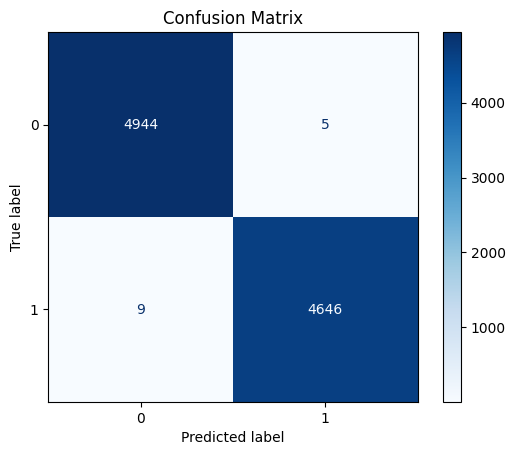

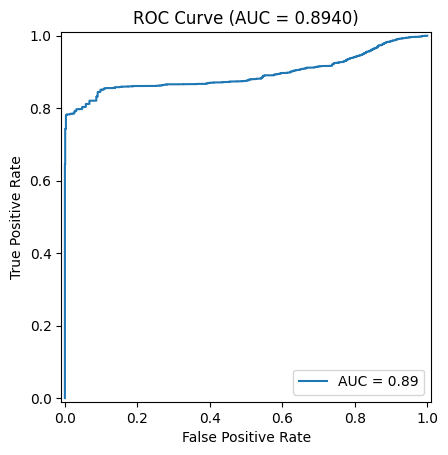

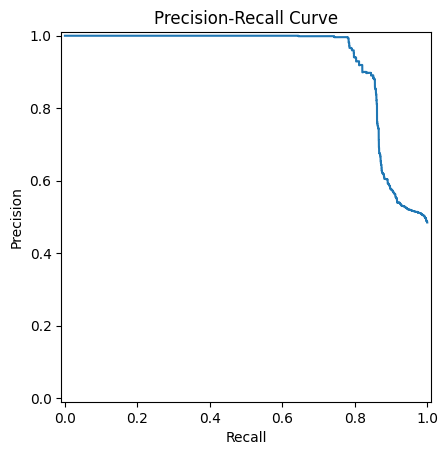

In [12]:
if __name__ == "__main__":
    # Load the dataset
    df = pd.read_csv("D:\Coding Projects\Detection-of-SYN-Flood-Attacks-Using-Machine-Learning-and-Deep-Learning-Techniques-with-Feature-Base\Data\K5_Dataset.csv")

    # Select first 12 feature columns (exclude label and fold info)
    feat_cols = df.columns.difference(["Label", "Fold"]).tolist()[:12]

    # Run cross-validation using a Self-Organizing Map
    accs = som_cross_validate(df, feat_cols)
    print("\nFinal SOM Cross-Validation Results:")
    print(f"Fold Accuracies: {accs}")

    # Train on the full dataset and generate evaluation plots
    som_visual_evaluation(df, feat_cols)